### Getting all of the imports

In [2]:
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

import warnings
warnings.filterwarnings('once')

### Loading data and a bit of preprocessing

In [3]:
data = fetch_dataset(name='h2o_exog', raw=True)

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [4]:
data

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199
...,...,...,...,...
190,2008-02-01,0.761822,1.515840,1.786373
191,2008-03-01,0.649435,1.506258,1.694264
192,2008-04-01,0.827887,1.505253,1.627135
193,2008-05-01,0.816255,1.491464,1.555068


In [5]:
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [6]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


### After we have dealt with missing values, our data is ready

In [7]:
data.to_csv("data.csv")

### Indexing the data

In [8]:
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

### Splitting the data

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


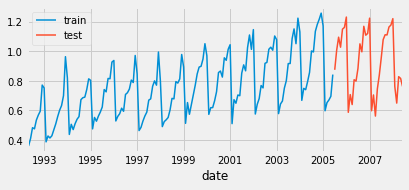

In [9]:
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend()

# Create and train forecaster


In [10]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-03 15:02:54 
Last fit date: 2024-05-03 15:02:54 
Skforecast version: 0.11.0 
Python version: 

## Making initial few predictions

In [11]:
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

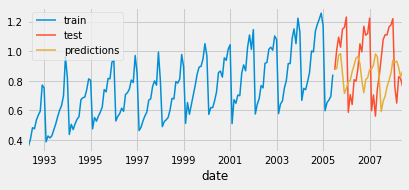

In [12]:
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [13]:
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.07326833976120374


## Hyperparameter tuning

In [14]:
# Hyperparameter grid search
steps = 36
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.021992765856921042



In [15]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.021993,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.022114,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.022224,10,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.022530,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.022569,3,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.023400,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.063144,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.064775,3,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.066307,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.067151,5,100


#### The best results are obtained using a time window of 20 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 500}. Create and train forecaster with the best hyperparameters and lags found


In [16]:
regressor = RandomForestRegressor(n_estimators=500, max_depth=3, random_state=123)

forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [17]:
predictions = forecaster.predict(steps=steps)

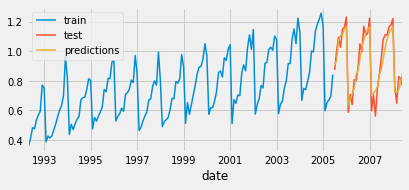

In [18]:
# Plot predictions versus test data
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [19]:
# Test error
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.004392699665157793


## Backtesting 

### We use the backtesting with refit strategy.
- In the first iteration, the model is trained with the observations selected for the initial training (in this case, 87). Then, the next 36 observations are used to validate the predictions of this first model.

- In the second iteration, the model is retrained by adding, to the initial training set, the previous 36 validation observations (87 + 36). In the same way, the next 36 observations are established as the new validation set.

This process is repeated until all available observations are used. Following this strategy, the training set increases in each iteration with as many observations as steps are being predicted.

In [22]:
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for the backtest


metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data['y'],
                                   initial_train_size = len(data) - n_backtesting,
                                   fixed_train_size   = False,
                                   steps              = steps,
                                   metric             = 'mean_squared_error',
                                #    refit              = True,
                                   verbose            = True,
                                   show_progress      = True
                               )


Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

: 

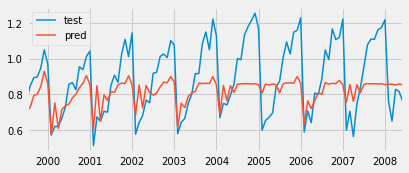

In [21]:
# Plot backtest predictions vs real values
fig, ax = plt.subplots(figsize=(6, 2.5))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend()

![alt text](./Figure_1.png "Title")

## Forecasting with exogenous variables

In [11]:
# Data download
data = fetch_dataset(name='h2o_exog', raw=True)

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


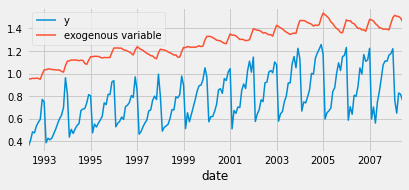

In [12]:
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(6, 2.5))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend()

In [13]:
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [14]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-03 02:22:40 
Last fit date: 2024-05-03 02:22:40 
Skforeca

### Since the ForecasterAutoreg has been trained with an exogenous variable, the value of this variable must be passed to predict(). The future information about the exogenous variable must be available when making predictions.

In [15]:
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

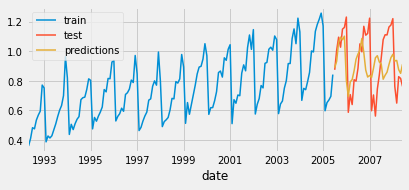

In [16]:
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [17]:
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.03989087922533575


### Forecasting with custom predictors

In [19]:
data = fetch_dataset(name='h2o_exog', raw=True)

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [20]:
# Data preparation
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [21]:
def custom_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """
    
    lags = y[-1:-11:-1]     # window size needed = 10
    mean = np.mean(y[-20:]) # window size needed = 20
    predictors = np.hstack([lags, mean])
    
    return predictors

In [22]:
forecaster = ForecasterAutoregCustom(
                 regressor      = RandomForestRegressor(random_state=123),
                 fun_predictors = custom_predictors,
                 window_size    = 20
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-03 02:25:04 
Last fit date: 2024-05-03 02:25:04 
Skfor

In [23]:
print(forecaster.source_code_fun_predictors)


def custom_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """
    
    lags = y[-1:-11:-1]     # window size needed = 10
    mean = np.mean(y[-20:]) # window size needed = 20
    predictors = np.hstack([lags, mean])
    
    return predictors



### Using the method create_train_X_y, is it posible to acces the matrices that are created internally in the training process.



In [24]:
X_train, y_train = forecaster.create_train_X_y(y=data_train['y'])

display(X_train.head(5))
display(y_train.head(5))

,custom_predictor_0,custom_predictor_1,custom_predictor_2,custom_predictor_3,custom_predictor_4,custom_predictor_5,custom_predictor_6,custom_predictor_7,custom_predictor_8,custom_predictor_9,custom_predictor_10
date,,,,,,,,,,,
1993-12-01,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.387554,0.523089
1994-01-01,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.552253
1994-02-01,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.575129
1994-03-01,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.576486
1994-04-01,0.506121,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.577622


date
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
1994-04-01    0.470491
Freq: MS, Name: y, dtype: float64

In [25]:
steps = 36
predictions = forecaster.predict(steps=steps)

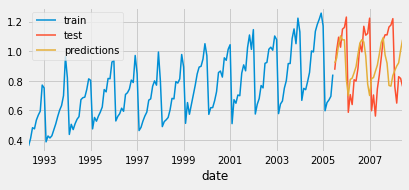

In [26]:
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [27]:
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.046232546768232


## Direct multi-step forecasting

In [28]:
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 steps         = 36,
                 lags          = 8,
                 transformer_y = StandardScaler()
             )

forecaster

ForecasterAutoregDirect 
Regressor: Ridge(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 8 
Maximum steps predicted: 36 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-05-03 02:26:47 
Last fit date: None 
Skforecast version: 0.11.0 
Python version: 3.8.10 
Forecaster id: None 

In [29]:
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 steps         = 36,
                 lags          = 8, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.2782559402207126}
  Backtesting metric: 0.02741394826520458



In [30]:
results_grid.head()


,lags,params,mean_squared_error,alpha
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.2782559402207126},0.027414,0.278256
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 3.593813663804626},0.027435,3.593814
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.021544346900318846},0.027484,0.021544
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0016681005372000592},0.027490,0.001668
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0001291549665014884},0.027491,0.000129


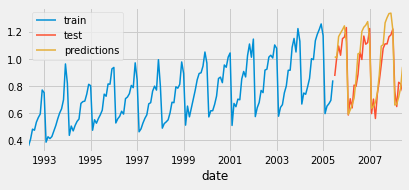

In [31]:
# Predictions
predictions = forecaster.predict()

# Plot predictions versus test data
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [32]:
error_mse = mean_squared_error(
                y_true = data_test['y'], 
                y_pred = predictions
            )

print(f"Test error (MSE) {error_mse}")

Test error (MSE) 0.011792965469623131
